# Walmart Demand Prediction - Time Series Forecasting

This notebook implements a forecasting system using multiple models to predict retail product demand with a focus on seasonal patterns.

## 1. Setting Up Environment

In [ ]:
!pip install pandas numpy matplotlib seaborn scikit-learn statsmodels prophet pmdarima

  Using cached pmdarima-2.0.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_28_x86_64.whl.metadata (7.8 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 102.4 MB/s eta 0:00:00
Using cached pmdarima-2.0.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_28_x86_64.whl (2.2 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.0
    Uninstalling numpy-1.23.0:
      Successfully uninstalled numpy-1.23.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 2.2.4 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.2.4 which is incompatible.


In [ ]:
# Force fresh install of compatible versions
!pip uninstall -y numpy pmdarima
!pip install --no-cache-dir numpy==1.23
!pip install --no-cache-dir pmdarima --no-binary :all:

Found existing installation: numpy 2.0.2
Uninstalling numpy-2.0.2:
  Successfully uninstalled numpy-2.0.2
Found existing installation: pmdarima 2.0.4
Uninstalling pmdarima-2.0.4:
  Successfully uninstalled pmdarima-2.0.4
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 133.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for numpy: filename=numpy-1.23.0-cp311-cp311-linux_x86_64.whl size=19729986 sha256=728ef1b9846dbbb110f1743c35b80a05cf4c71f5d48de7589d89cc21d7bed1e0
  Stored in directory: /tmp/pip-ephem-wheel-cache-21u_eu3s/wheels/6d/36/1a/3ec6b85008bea3151efb003f5d41baa7bf4966cb43c1c2470b
Successfully built numpy
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-contrib-python 4.11.0.86 requires numpy>=1.23.5; python_version >=

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 630.3/630.3 kB 21.5 MB/s eta 0:00:00
  Installing build dependencies ... canceled^C


In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error
import statsmodels.api as sm
from prophet import Prophet
from pmdarima import auto_arima
import warnings
warnings.filterwarnings('ignore')

## 2. Data Acquisition

In [ ]:
# Install Kaggle and download dataset
!pip install kaggle -q

# Upload Kaggle API credentials
# Note: You'll need to upload your kaggle.json file
from google.colab import files
# Run this and upload your kaggle.json when prompted
try:
  files.upload()  # This will prompt you to upload kaggle.json
  !mkdir -p ~/.kaggle
  !cp kaggle.json ~/.kaggle/
  !chmod 600 ~/.kaggle/kaggle.json
  print("Kaggle credentials uploaded successfully!")
except:
  print("Please make sure to upload your kaggle.json file for API access")

# Download the dataset
!kaggle datasets download -d yasserh/walmart-dataset
!unzip walmart-dataset.zip

Saving kaggle.json to kaggle.json
Kaggle credentials uploaded successfully!
Dataset URL: https://www.kaggle.com/datasets/yasserh/walmart-dataset
License(s): CC0-1.0
Archive:  walmart-dataset.zip
  inflating: Walmart.csv             


## 3. Data Loading and Exploration

In [ ]:
# Load the dataset
df = pd.read_csv('Walmart.csv')

# Display basic information
print("Dataset shape:", df.shape)
df.head()

# Check for missing values
print("\nMissing values:", df.isnull().sum())

# Data types
print("\nData types:")
print(df.dtypes)

# Basic statistics
print("\nBasic statistics:")
print(df.describe())

Dataset shape: (6435, 8)

Missing values: Store           0
Date            0
Weekly_Sales    0
Holiday_Flag    0
Temperature     0
Fuel_Price      0
CPI             0
Unemployment    0
dtype: int64

Data types:
Store             int64
Date             object
Weekly_Sales    float64
Holiday_Flag      int64
Temperature     float64
Fuel_Price      float64
CPI             float64
Unemployment    float64
dtype: object

Basic statistics:
             Store  Weekly_Sales  Holiday_Flag  Temperature   Fuel_Price  \
count  6435.000000  6.435000e+03   6435.000000  6435.000000  6435.000000   
mean     23.000000  1.046965e+06      0.069930    60.663782     3.358607   
std      12.988182  5.643666e+05      0.255049    18.444933     0.459020   
min       1.000000  2.099862e+05      0.000000    -2.060000     2.472000   
25%      12.000000  5.533501e+05      0.000000    47.460000     2.933000   
50%      23.000000  9.607460e+05      0.000000    62.670000     3.445000   
75%      34.000000  1.420159e+0

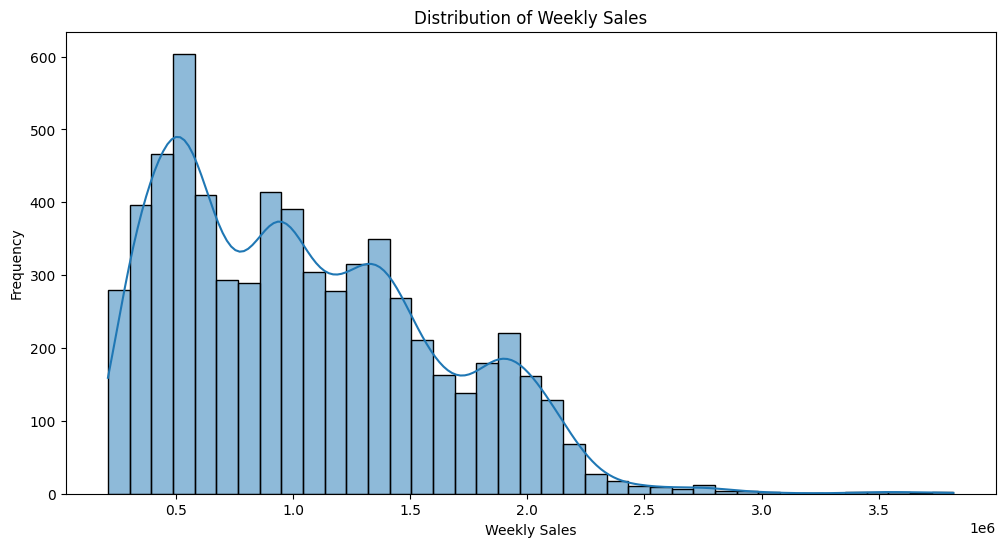

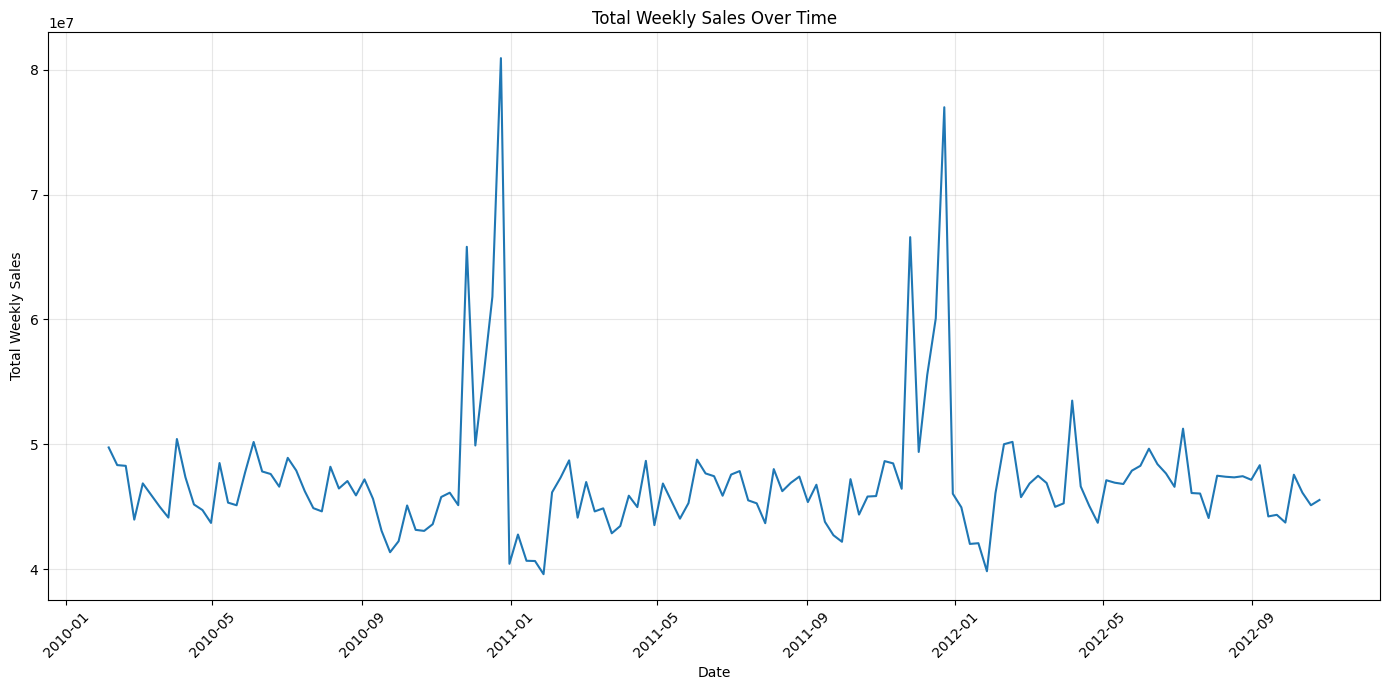

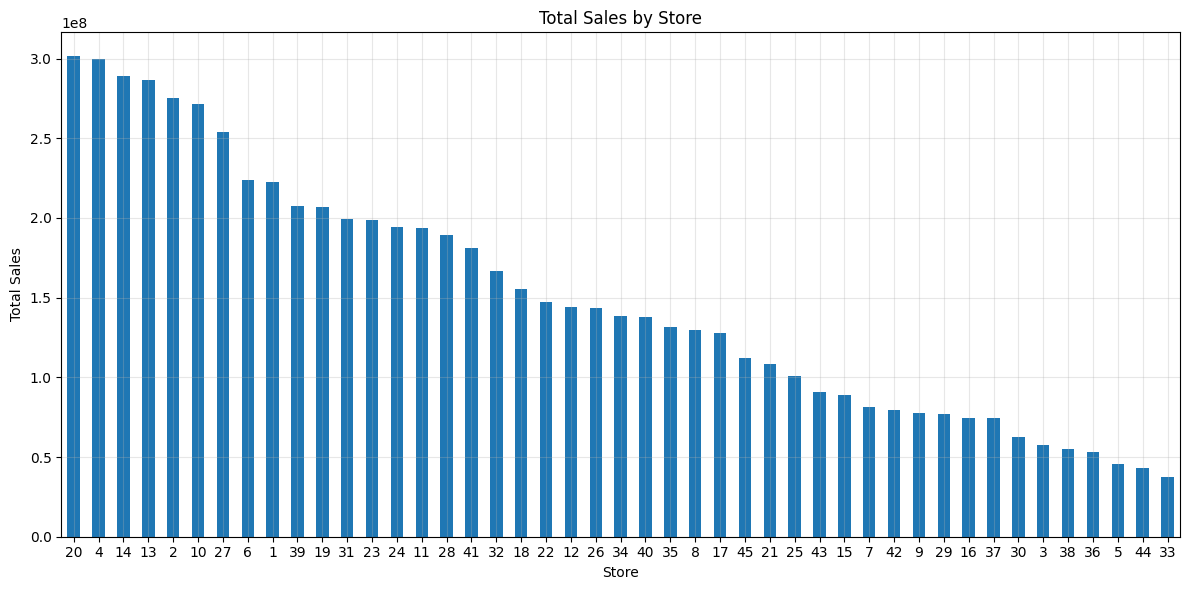

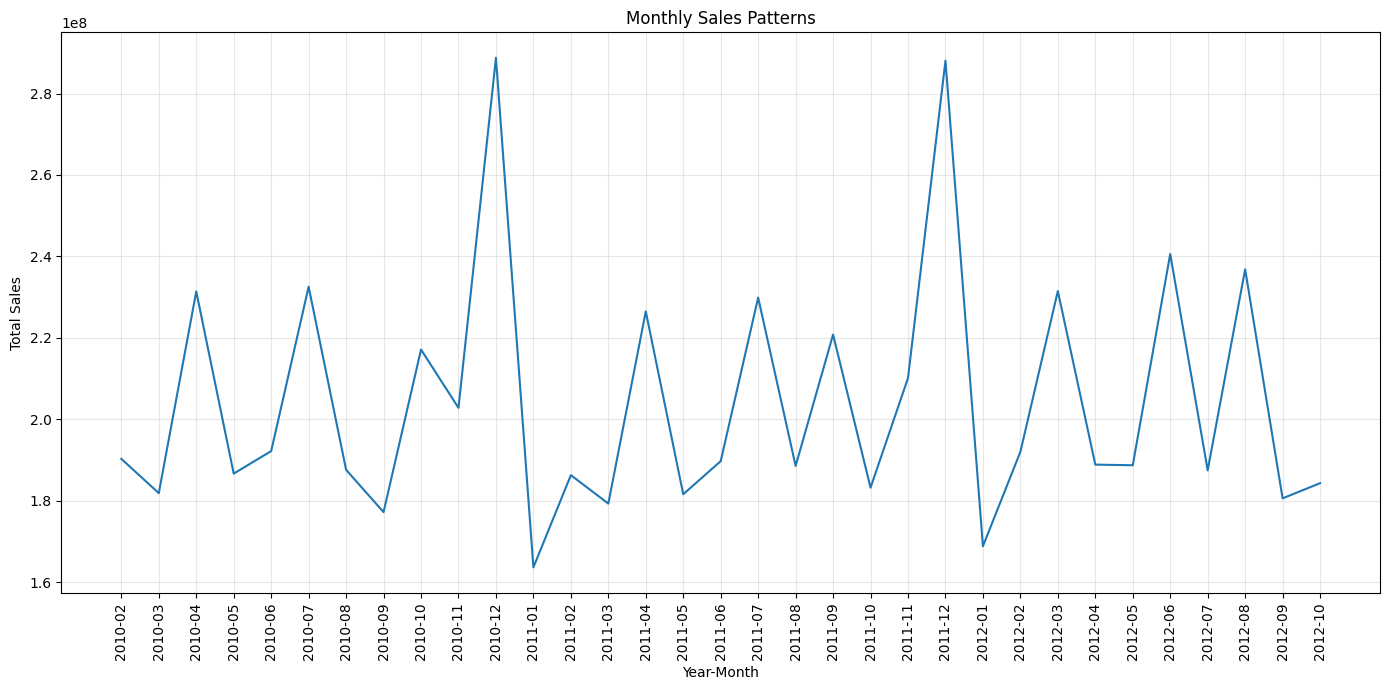

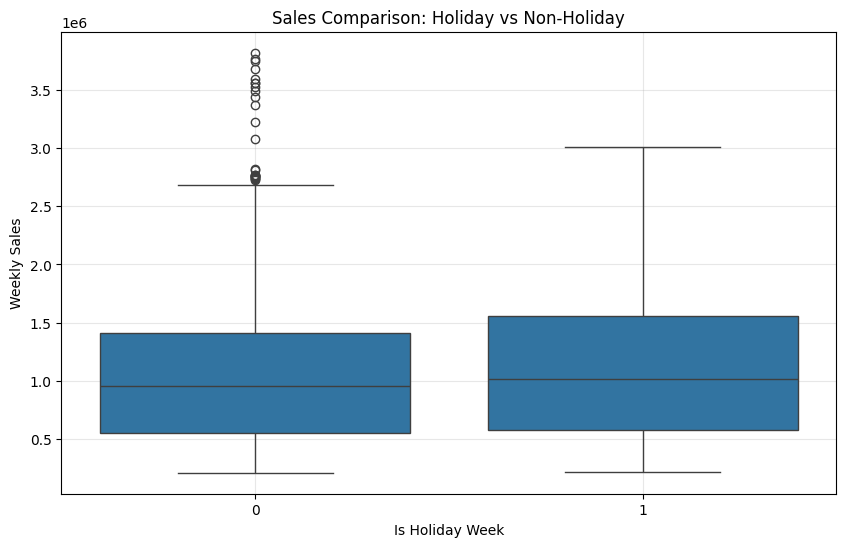

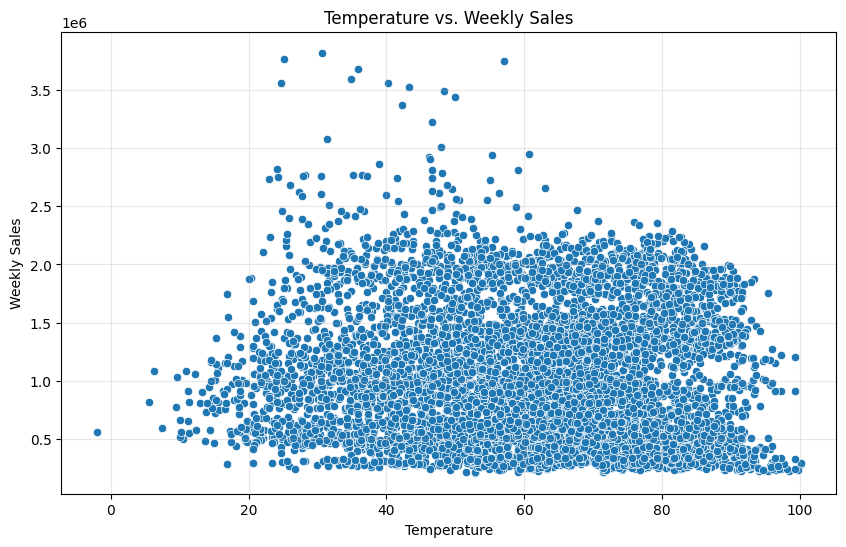

In [ ]:
# 4. Exploratory Data Analysis
# ---------------------------

# Convert date column to datetime
df['Date'] = pd.to_datetime(df['Date'], dayfirst = True)

# Extract time-based features
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Week'] = df['Date'].dt.isocalendar().week
df['Day'] = df['Date'].dt.day
df['DayOfWeek'] = df['Date'].dt.dayofweek

# Plot weekly sales distribution
plt.figure(figsize=(12, 6))
sns.histplot(df['Weekly_Sales'], kde=True)
plt.title('Distribution of Weekly Sales')
plt.xlabel('Weekly Sales')
plt.ylabel('Frequency')
plt.show()

# Sales trend over time - aggregate by date
sales_by_date = df.groupby('Date')['Weekly_Sales'].sum().reset_index()

plt.figure(figsize=(14, 7))
plt.plot(sales_by_date['Date'], sales_by_date['Weekly_Sales'])
plt.title('Total Weekly Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Total Weekly Sales')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Store-wise sales comparison
store_sales = df.groupby('Store')['Weekly_Sales'].sum().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
store_sales.plot(kind='bar')
plt.title('Total Sales by Store')
plt.xlabel('Store')
plt.ylabel('Total Sales')
plt.xticks(rotation=0)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Seasonal patterns - Monthly sales
monthly_sales = df.groupby(['Year', 'Month'])['Weekly_Sales'].sum().reset_index()
monthly_sales['YearMonth'] = monthly_sales['Year'].astype(str) + '-' + monthly_sales['Month'].astype(str).str.zfill(2)

plt.figure(figsize=(14, 7))
sns.lineplot(x='YearMonth', y='Weekly_Sales', data=monthly_sales)
plt.title('Monthly Sales Patterns')
plt.xlabel('Year-Month')
plt.ylabel('Total Sales')
plt.xticks(rotation=90)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Holiday effect
plt.figure(figsize=(10, 6))
sns.boxplot(x='Holiday_Flag', y='Weekly_Sales', data=df)
plt.title('Sales Comparison: Holiday vs Non-Holiday')
plt.xlabel('Is Holiday Week')
plt.ylabel('Weekly Sales')
plt.grid(True, alpha=0.3)
plt.show()

# Temperature vs. Sales (if available)
if 'Temperature' in df.columns:
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='Temperature', y='Weekly_Sales', data=df)
    plt.title('Temperature vs. Weekly Sales')
    plt.xlabel('Temperature')
    plt.ylabel('Weekly Sales')
    plt.grid(True, alpha=0.3)
    plt.show()

In [ ]:
print(df.columns)

Index(['Store', 'Date', 'Weekly_Sales', 'Holiday_Flag', 'Temperature',
       'Fuel_Price', 'CPI', 'Unemployment', 'Year', 'Month', 'Week', 'Day',
       'DayOfWeek'],
      dtype='object')


## 5. Data Preprocessing

Data for Store 1


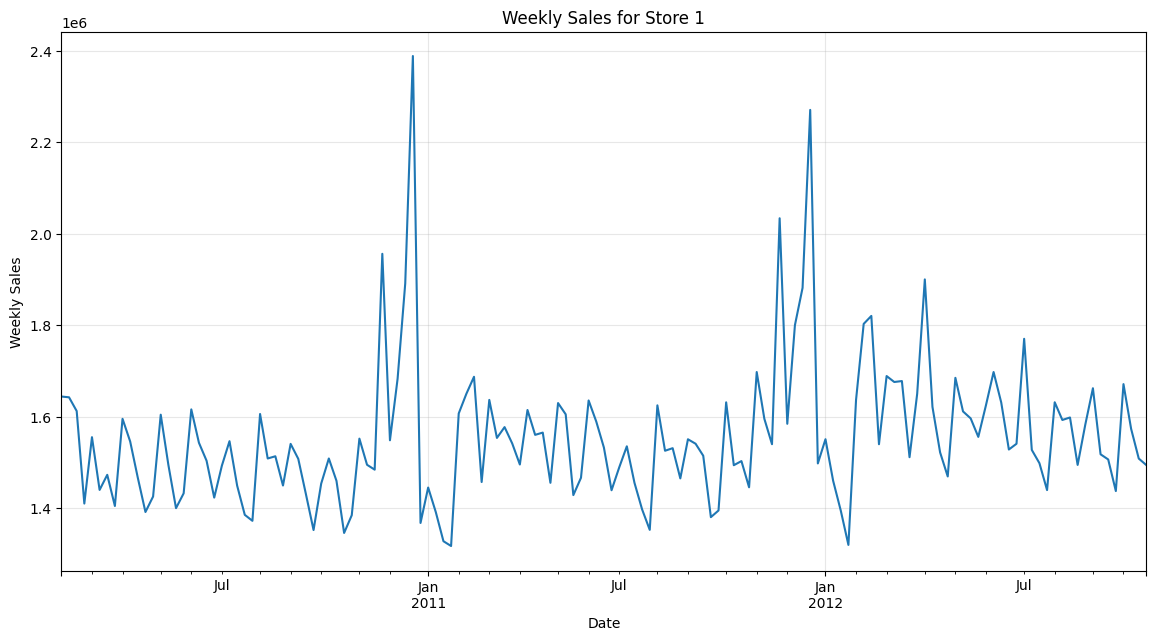

In [ ]:
# Choose a single store and department for analysis
# You can modify this to analyze multiple stores/departments
store_id = 1
dept_id = 1
store_data = df[(df['Store'] == store_id)].copy()

# Ensure data is sorted by date
store_data = store_data.sort_values('Date')
print(f"Data for Store {store_id}")
store_data.head()

# Create a time series dataset
time_series = store_data.set_index('Date')['Weekly_Sales']

# Plot the time series
plt.figure(figsize=(14, 7))
time_series.plot()
plt.title(f'Weekly Sales for Store {store_id}')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.grid(True, alpha=0.3)
plt.show()

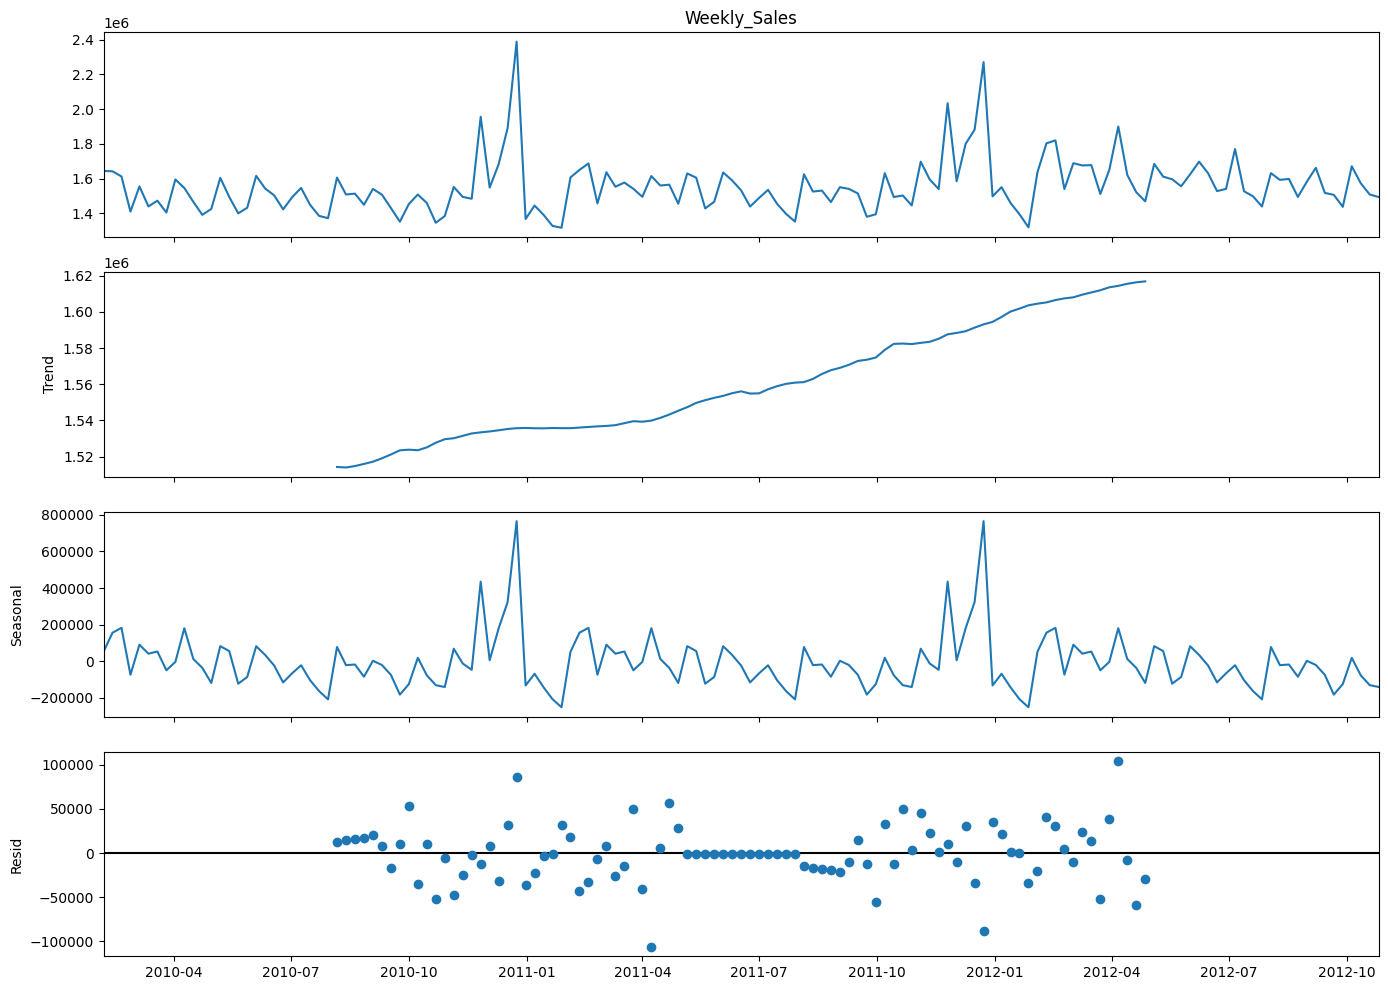

Training data size: 114
Testing data size: 29


In [ ]:
# 6. Time Series Analysis
# ----------------------

# Seasonal Decomposition
decomposition = sm.tsa.seasonal_decompose(time_series, model='additive', period=52)

fig = decomposition.plot()
fig.set_size_inches(14, 10)
plt.tight_layout()
plt.show()

# 7. Model Building
# ----------------

# Split data into train and test
train_size = int(len(time_series) * 0.8)
train_data = time_series[:train_size]
test_data = time_series[train_size:]

print(f"Training data size: {len(train_data)}")
print(f"Testing data size: {len(test_data)}")

## 7.1 ARIMA Model

In [ ]:
# Find optimal ARIMA parameters
arima_model = auto_arima(train_data,
                         seasonal=True,
                         m=52,  # Weekly data (52 weeks in a year)
                         start_p=0,
                         start_q=0,
                         max_p=3,
                         max_q=3,
                         d=None,
                         D=1,
                         trace=True,
                         error_action='ignore',
                         suppress_warnings=True,
                         stepwise=True)

print(arima_model.summary())

# Forecast using ARIMA
arima_forecast = arima_model.predict(len(test_data))
arima_forecast = pd.Series(arima_forecast, index=test_data.index)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,1,1)[52] intercept   : AIC=inf, Time=8.00 sec
 ARIMA(0,0,0)(0,1,0)[52] intercept   : AIC=1559.026, Time=0.11 sec
 ARIMA(1,0,0)(1,1,0)[52] intercept   : AIC=1563.434, Time=4.74 sec
 ARIMA(0,0,1)(0,1,1)[52] intercept   : AIC=1560.746, Time=1.98 sec
 ARIMA(0,0,0)(0,1,0)[52]             : AIC=1603.907, Time=0.10 sec
 ARIMA(0,0,0)(1,1,0)[52] intercept   : AIC=1559.286, Time=2.14 sec
 ARIMA(0,0,0)(0,1,1)[52] intercept   : AIC=1559.177, Time=0.90 sec
 ARIMA(1,0,0)(0,1,0)[52] intercept   : AIC=1561.595, Time=0.20 sec
 ARIMA(0,0,1)(0,1,0)[52] intercept   : AIC=1560.174, Time=0.28 sec
 ARIMA(1,0,1)(0,1,0)[52] intercept   : AIC=1561.855, Time=0.42 sec

Best model:  ARIMA(0,0,0)(0,1,0)[52] intercept
Total fit time: 18.914 seconds
                                SARIMAX Results                                 
Dep. Variable:                        y   No. Observations:                  114
Model:             SARIMAX(0, 1, 0, 52)   Log Likel

## 7.2 Prophet Model

In [ ]:
# Prepare data for Prophet
prophet_data = pd.DataFrame({
    'ds': train_data.index,
    'y': train_data.values
})

# Initialize and fit Prophet model
prophet_model = Prophet(yearly_seasonality=True,
                       weekly_seasonality=True,
                       daily_seasonality=False,
                       seasonality_mode='additive')

if 'Holiday_flag' in store_data.columns:
    # Add holiday information if available
    holidays = store_data[store_data['Holiday_flag'] == True]
    holidays = pd.DataFrame({
        'ds': pd.to_datetime(holidays['Date']),
        'holiday': 'holiday'
    })
    prophet_model.add_country_holidays(country_name='US')

prophet_model.fit(prophet_data)

# Create future dataframe for prediction
future = pd.DataFrame({'ds': test_data.index})
prophet_forecast = prophet_model.predict(future)

# Extract forecast
prophet_pred = prophet_forecast['yhat']
prophet_pred.index = test_data.index

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7651p94m/1n1msd8d.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7651p94m/rg9gj4yf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50679', 'data', 'file=/tmp/tmp7651p94m/1n1msd8d.json', 'init=/tmp/tmp7651p94m/rg9gj4yf.json', 'output', 'file=/tmp/tmp7651p94m/prophet_modelctkyto6w/prophet_model-20250415213131.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:31:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:31:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


## 8. Ensemble Model

In [ ]:
# Simple average ensemble
ensemble_forecast = (arima_forecast + prophet_pred) / 2

## 9. Model Evaluation

In [ ]:
# Calculate metrics
def calculate_metrics(actual, predicted):
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    return mae, rmse, mape

# ARIMA metrics
arima_mae, arima_rmse, arima_mape = calculate_metrics(test_data, arima_forecast)
print(f"ARIMA - MAE: {arima_mae:.2f}, RMSE: {arima_rmse:.2f}, MAPE: {arima_mape:.2f}%")

# Prophet metrics
prophet_mae, prophet_rmse, prophet_mape = calculate_metrics(test_data, prophet_pred)
print(f"Prophet - MAE: {prophet_mae:.2f}, RMSE: {prophet_rmse:.2f}, MAPE: {prophet_mape:.2f}%")

# Ensemble metrics
ensemble_mae, ensemble_rmse, ensemble_mape = calculate_metrics(test_data, ensemble_forecast)
print(f"Ensemble - MAE: {ensemble_mae:.2f}, RMSE: {ensemble_rmse:.2f}, MAPE: {ensemble_mape:.2f}%")

ARIMA - MAE: 42521.86, RMSE: 56471.72, MAPE: 2.67%
Prophet - MAE: 61841.33, RMSE: 79892.34, MAPE: 3.95%
Ensemble - MAE: 41896.04, RMSE: 57758.26, MAPE: 2.65%


## 10. Visualization of Results

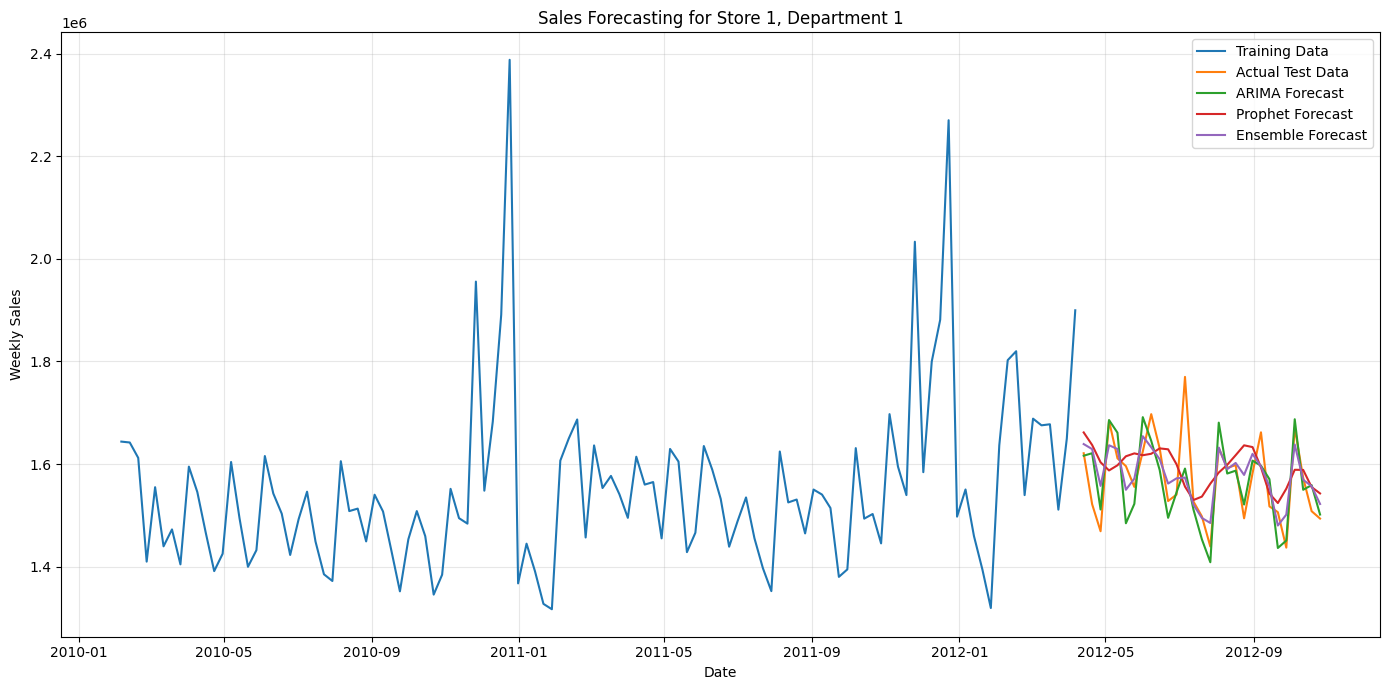

In [ ]:
plt.figure(figsize=(14, 7))
plt.plot(train_data.index, train_data, label='Training Data')
plt.plot(test_data.index, test_data, label='Actual Test Data')
plt.plot(test_data.index, arima_forecast, label='ARIMA Forecast')
plt.plot(test_data.index, prophet_pred, label='Prophet Forecast')
plt.plot(test_data.index, ensemble_forecast, label='Ensemble Forecast')
plt.title(f'Sales Forecasting for Store {store_id}, Department {dept_id}')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 11. Future Forecasting

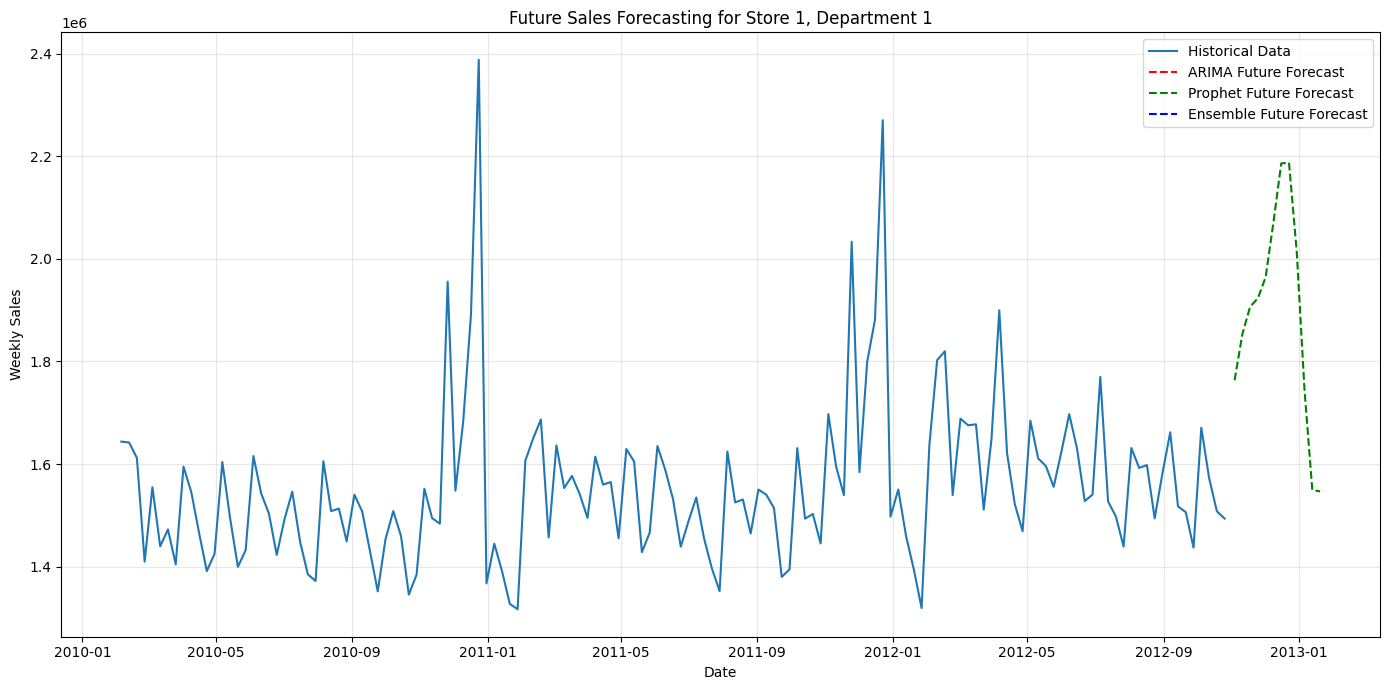

In [ ]:
# Generate dates for future forecasting (next 12 weeks)
last_date = time_series.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=7), periods=12, freq='W')

# ARIMA future forecast
arima_future = arima_model.predict(12)
arima_future = pd.Series(arima_future, index=future_dates)

# Prophet future forecast
future_prophet = pd.DataFrame({'ds': pd.concat([pd.Series(time_series.index), pd.Series(future_dates)])})
prophet_future_forecast = prophet_model.predict(future_prophet)
prophet_future = prophet_future_forecast['yhat'][-12:]
prophet_future.index = future_dates

# Ensemble future forecast
ensemble_future = (arima_future + prophet_future) / 2

# Plot future forecasts
plt.figure(figsize=(14, 7))
plt.plot(time_series.index, time_series, label='Historical Data')
plt.plot(future_dates, arima_future, 'r--', label='ARIMA Future Forecast')
plt.plot(future_dates, prophet_future, 'g--', label='Prophet Future Forecast')
plt.plot(future_dates, ensemble_future, 'b--', label='Ensemble Future Forecast')
plt.title(f'Future Sales Forecasting for Store {store_id}, Department {dept_id}')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 12. Conclusion

In [ ]:
print("Model Performance Summary:")
print(f"ARIMA - MAE: {arima_mae:.2f}, RMSE: {arima_rmse:.2f}, MAPE: {arima_mape:.2f}%")
print(f"Prophet - MAE: {prophet_mae:.2f}, RMSE: {prophet_rmse:.2f}, MAPE: {prophet_mape:.2f}%")
print(f"Ensemble - MAE: {ensemble_mae:.2f}, RMSE: {ensemble_rmse:.2f}, MAPE: {ensemble_mape:.2f}%")

# Model with the best performance
best_model = min(["ARIMA", "Prophet", "Ensemble"],
                key=lambda x: [arima_mape, prophet_mape, ensemble_mape][["ARIMA", "Prophet", "Ensemble"].index(x)])

print(f"\nBest performing model: {best_model}")
print(f"Accuracy: {100 - min(arima_mape, prophet_mape, ensemble_mape):.2f}%")

Model Performance Summary:
ARIMA - MAE: 42521.86, RMSE: 56471.72, MAPE: 2.67%
Prophet - MAE: 61841.33, RMSE: 79892.34, MAPE: 3.95%
Ensemble - MAE: 41896.04, RMSE: 57758.26, MAPE: 2.65%

Best performing model: Ensemble
Accuracy: 97.35%
